# Appendix - Machine Learned Debt Price Model
In this document we explore using machine learning methods to model the debt price. 

We approximate the debt price as the 10-days exponential moving average (EMA) of the market price. We then use activity data from Single Collateral DAI to fit a regression model that accurately predicts the debt price from the following feature set:
* $Q$: WETH locked in Maker
* $v_1$: daily WETH deposited
* $v_2+v_3$: daily WETH withdrawn
* $D_1$: SAI supply / total principal debt
* $u_1$: daily SAI minted / new debt taken out
* $u_2$: daily principal debt paid back
* $u_3$: daily principal debt liquidated
* $u_2+u_3$: daily SAI burned
* $D_2$: interest component of total debt
* $w_1$: daily interest accrued
* $w_2$: daily interest paid back
* $w_3$: daily interest waived
* $w_2+w_3$: daily decrease in interest component of total debt
* $D = D_1 + D_2$: total debt in the system
* $\beta$: stability fee
* $\rho^*$: price of ETH in USD
* $C^* = Q  \rho^*$: total value locked in Maker

For efficiency, we use the [AutoSklearn](http://papers.nips.cc/paper/5872-efficient-and-robust-automated-machine-learning.pdf) package to train the regressor. AutoSklearn is an automated machine learning system based on scikit-learn which leverages Bayesian optimization, meta-learning and ensemble construction to automatically select a combination of ML algorithms and tune their hyperparameters. A more traditional approach could be explored in future iterations of this project to increase transparency and control over the model.

Other iterations of this approach can be found in [previous commits](https://github.com/BlockScience/reflexer/blob/9ee1b81ddb81848911a1249bd2ebaddcebb6a0d8/data/debt_price_ml_methods.ipynb) of this notebook. In them we explored:
* defining the debt price as equal to the market price instead of its 10-days EMA
* different test sample sizes
* holdout and cross validation as resampling strategies

The decision to use the 10-days EMA as a proxy for the debt price was made based on the notion that the debt price being a more intrinsic value it should be less noisy than the market price.

Different test sample sizes and resampling strategies had similar results, and we settled for a 66/33 training/test split and a 5-fold cross validation strategy.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from autosklearn.regression import AutoSklearnRegressor
from autosklearn.metrics import mean_squared_error as auto_mean_squared_error
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pyparsing.py:3172: FutureWarning: Possible set intersection at position 3
  self.re = re.compile(self.reString)


In [2]:
# load dataset
debt_market_df = pd.read_csv('data/debt_market_df.csv', index_col='date', parse_dates=True)


def fitmodel(data_to_fit=debt_market_df, 
             data_to_predict=debt_market_df, 
             target_col='p',
             features=None, 
             verbose=False, 
             test_size=0.33
            ):
    if not features:
        features = ['beta', 'Q', 'v_1', 'v_2 + v_3', 
                    'rho_star', 'C_star',
                    'D_1', 'u_1', 'u_2', 'u_3', 'u_2 + u_3', 
                    'D_2', 'w_1', 'w_2', 'w_3', 'w_2 + w_3',
                    'D']
    target = data_to_fit[target_col].copy()
    
    data_to_fit = data_to_fit[features]
    data_to_predict = data_to_predict[features]
    
    X_train, X_test, y_train, y_test = train_test_split(data_to_fit, target, test_size=test_size, random_state=1)
    
    model = AutoSklearnRegressor(time_left_for_this_task=5*60, 
                                 per_run_time_limit=30, 
                                 n_jobs=8,
                                 resampling_strategy='cv',
                                 resampling_strategy_arguments={'folds':5}
                                )
    model.fit(X_train, y_train)
    if verbose:
        print(model.sprint_statistics())
        models = model.get_models_with_weights()
        for m in models:
            print({m[0]: m[1].config['regressor:__choice__']})
    return model, model.predict(data_to_predict), y_test, model.predict(X_test)

def get_model_summary(model):
    result = []
    models = model.get_models_with_weights()
    for m in models:
        result.append((m[0],m[1].config['regressor:__choice__']))
    return result

In [3]:
p_ema_estimates = pd.DataFrame(debt_market_df['p_ema_10'])
i = 1

Fitting model using 66% of the data for training
[WARNING] [2020-09-16 16:59:55,708:AutoMLSMBO(1791095845)::f55f7e85530272cf61a7d06b7f6532dd] Could not find meta-data directory /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/autosklearn/metalearning/files/r2_regression_dense
auto-sklearn results:
  Dataset name: f55f7e85530272cf61a7d06b7f6532dd
  Metric: r2
  Best validation score: 0.908773
  Number of target algorithm runs: 90
  Number of successful target algorithm runs: 57
  Number of crashed target algorithm runs: 1
  Number of target algorithms that exceeded the time limit: 32
  Number of target algorithms that exceeded the memory limit: 0

{0.34: 'k_nearest_neighbors'}
{0.24: 'k_nearest_neighbors'}
{0.18: 'adaboost'}
{0.14: 'k_nearest_neighbors'}
{0.06: 'k_nearest_neighbors'}
{0.04: 'ridge_regression'}
R2: 0.9173277787633343
[(0.34, 'k_nearest_neighbors'),
 (0.24, 'k_nearest_neighbors'),
 (0.18, 'adaboost'),
 (0.14, 'k_nearest_neighbors'),
 (0.06, 'k

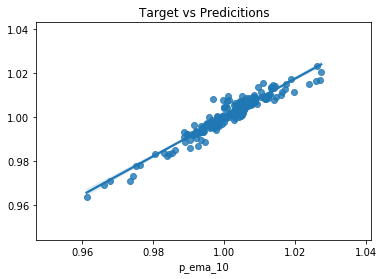

In [4]:
print('Fitting model using 66% of the data for training')
model, full_prediction, y_test, predicted_y_test = fitmodel(test_size=0.34, target_col='p_ema_10', verbose=True)
r2 = r2_score(y_test,predicted_y_test)
print(f'R2: {r2}')
p_ema_estimates[f'p_ema_hat_{i} R2={r2:.2f}'] = full_prediction
pprint(get_model_summary(model))
sns.regplot(y_test, predicted_y_test).set_title('Target vs Predicitions');
print('---')
i += 1

As can be seen in the output of the fitting process, 57 algorithms were run, with an ensemble of 6 of them resulting in the best validation score $R^2=0.91$. A similar score was obtained in the testing data ($R^2=0.92$). The following plot shows the 10-days EMA of the market price (blue) and the values predicted by the model (orange).

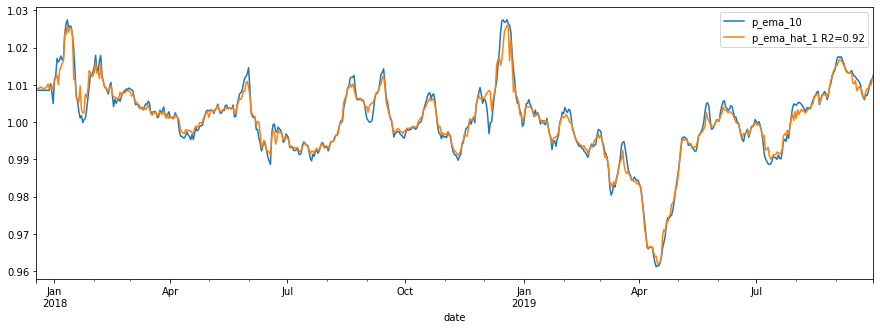

In [5]:
p_ema_estimates.plot(figsize=(15,5))

Finally, we store the model to a file so that it can be used in a cadCAD model in the next steps of the project and verify the consistency of the model loaded from the file against the original.

In [6]:
# Store the last model in a file and load it to check the predictions match
import pickle
pickle.dump(model, open('debt_price_estimator.pickle', 'wb'))
loaded_model = pickle.load(open('debt_price_estimator.pickle', 'rb'))

features = ['beta', 'Q', 'v_1', 'v_2 + v_3', 
            'rho_star', 'C_star',
            'D_1', 'u_1', 'u_2', 'u_3', 'u_2 + u_3', 
            'D_2', 'w_1', 'w_2', 'w_3', 'w_2 + w_3',
            'D']

data_to_predict = debt_market_df[features]
loaded_model_predictions = loaded_model.predict(data_to_predict)
print(f'Prediction by the model loaded from file matches original: {(full_prediction==loaded_model_predictions).all()}')

Prediction by the model loaded from file matches original: True
